<a href="https://colab.research.google.com/github/cameronbrown100/induction_time_prediction/blob/main/Induction_time_distribution_synthetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf 
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.utils import shuffle
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Layer, Input
from sklearn.model_selection import train_test_split

In [19]:
def t(P, S):
    A = 130.7
    B = 0.25
    V = 1e-5
    tg = 0

    J = A * S * np.exp(-B/np.log(S)**2)
    t = np.round((np.log(1-P))/(-J*V),0)+tg
    return t

In [20]:
def data_generator(S, samples):
    P = np.random.rand(samples)
    return t(P, S)

In [21]:
samples = 100

S_vals = np.arange(1.4, 2, 0.05)
S_arr = np.array([])
t_arr = np.array([])

for S in S_vals:
    S_arr = np.append(S_arr, np.full(samples,S))
    t_arr = np.append(t_arr, data_generator(S, samples))

S_arr, t_arr = shuffle(S_arr, t_arr)
S_test = np.arange(1.4, 2, 0.05)    

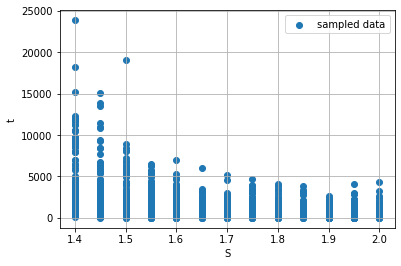

In [22]:
plt.grid(True)
plt.xlabel('S')
plt.ylabel('t')
plt.scatter(S_arr, t_arr, label = 'sampled data')
plt.legend(loc = 'upper right')
plt.show()

In [23]:
epochs = 500
batch_size = 50
learning_rate = 0.01

log_t_arr = np.log(t_arr)

model = Sequential()
model.add(Dense(12,input_shape=(1,),activation="tanh"))
model.add(Dense(12,activation="tanh"))
model.add(Dense(12,activation="tanh"))
model.add(Dense(1,activation="linear"))
adamOptimizer = tf.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='mse',optimizer=adamOptimizer,metrics=['mse'])
history_cache = model.fit(S_arr,
                          log_t_arr,
                          verbose=0, # write =1 if you wish to see the progress for each epoch
                          epochs=epochs,
                          batch_size=batch_size)
print('Final cost: {0:.4f}'.format(history_cache.history['loss'][-1]))

Final cost: 1.5380


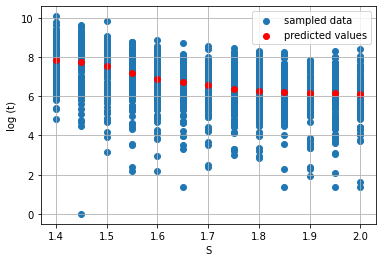

In [25]:
t_pred = np.exp(model.predict(S_test))

plt.grid(True)
plt.xlabel('S')
plt.ylabel('log (t)')
plt.scatter(S_arr, np.log(t_arr), label = 'sampled data')
plt.scatter(S_test,np.log(t_pred), c='r', label='predicted values')
plt.legend(loc='upper right')
plt.show()

In [26]:
def mdn_cost(mu, sigma, y):
    dist = tfp.distributions.Normal(loc=mu, scale=sigma)
    return tf.reduce_mean(-dist.log_prob(y))

In [27]:
epochs = 500
batch_size = 50
learning_rate = 0.001

log_t_arr = np.log(t_arr)

InputLayer = Input(shape=(1,))
Layer_1 = Dense(12,activation="tanh")(InputLayer)
Layer_2 = Dense(12,activation="tanh")(Layer_1)
Layer_3 = Dense(12,activation="tanh")(Layer_2)
mu = Dense(1, activation="linear")(Layer_3)
sigma = Dense(1, activation=lambda x: tf.nn.elu(x) + 1)(Layer_3)
y_real = Input(shape=(1,))
lossF = mdn_cost(mu,sigma,y_real)
model = Model(inputs=[InputLayer, y_real], outputs=[mu, sigma])
model.add_loss(lossF)
adamOptimizer = tf.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=adamOptimizer,metrics=['mse'])
history_cache = model.fit([S_arr, log_t_arr], #notice we are using an input to pass the real values due to the inner workings of keras
                          verbose=0, # write =1 if you wish to see the progress for each epoch
                          epochs=epochs,
                          batch_size=batch_size)
print('Final cost: {0:.4f}'.format(history_cache.history['loss'][-1]))

Final cost: 1.6351


In [28]:
mu_pred, sigma_pred = model.predict(list((S_test,S_test))) # the model expects a list of arrays as it has 2 inputs
df = pd.concat([pd.DataFrame(data=mu_pred, columns = ['mu_pred']), pd.DataFrame(data=sigma_pred, columns = ['sigma_pred'])], axis = 1)

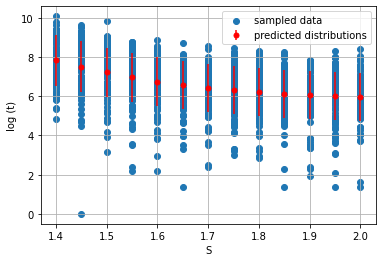

In [31]:
plt.grid(True)
plt.xlabel('S')
plt.ylabel('log (t)')
plt.scatter(S_arr, np.log(t_arr), label = 'sampled data')
plt.errorbar(S_test, df['mu_pred'], yerr=df['sigma_pred'], xerr=None,c='r',ls='None',marker='.',ms=10,label='predicted distributions')
plt.legend(loc='upper right')
plt.show()